### standard imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from botorch.models.gp_regression import SingleTaskGP
from tqdm import tqdm
from torch import Tensor
from botorch.acquisition.active_learning import (
    MCSampler,
    qNegIntegratedPosteriorVariance,
)

from botorch.fit import fit_gpytorch_mll
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer,StandardScaler
from botorch.models.gp_regression import SingleTaskGP

from sklearn.metrics import mean_absolute_error
import torch
from gpytorch.mlls import ExactMarginalLogLikelihood

# from botorch.models.transforms.input import Normalize
# from botorch.models.transforms.outcome import Standardize
import os 

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import warnings
import random
import torch
import pandas as pd
# from botorch.models.transforms.input import Normalize, Standardize
from botorch.utils.transforms import normalize, standardize

# warnings.filterwarnings("ignore", category=botorch.exceptions.BotorchWarning)

from botorch.exceptions.warnings import BotorchTensorDimensionWarning, InputDataWarning
warnings.filterwarnings(
            "ignore",
            message="Input data is not standardized.",
            category=InputDataWarning,
        )
import warnings
warnings.filterwarnings("ignore")
        

### checking my working directory so i can make sure to import my data file correctly


In [3]:
os.getcwd()

'/Users/ramseyissa/Documents/GitHub/qNIPV/notebooks'

In [4]:
df = pd.read_csv('../datasets/AutoAM_dataset.csv')
df

,Prime Delay,Print Speed,X Offset Correction,Y Offset Correction,Score
0,0.000000,1.000000,0.000000,0.000000,0.339554
1,2.500000,3.000000,0.100000,0.100000,0.000000
2,5.000000,5.000000,-0.100000,-0.100000,0.218576
3,0.000000,0.999931,0.000006,0.000025,0.368919
4,0.000000,5.070133,0.225151,1.000000,0.000000
...,...,...,...,...,...
95,0.742365,1.714610,-0.380317,-0.416497,0.829756
96,0.000000,1.585934,-0.337143,-0.372811,0.922120
97,0.000000,1.568030,-0.335316,-0.365804,0.901296
98,0.000000,1.558826,-0.349834,-0.328645,0.936549


### converting my data into a tensor / and normalizing 

In [5]:
xlower_bounds = []
xupper_bounds = []
x_vals = df.iloc[:,:-1]
for col in x_vals.columns:
    xlower = x_vals[col].min()
    xupper = x_vals[col].max()
    xlower_bounds.append(xlower)
    xupper_bounds.append(xupper)
    
    

In [6]:
xlower_bounds = torch.tensor(xlower_bounds, dtype=torch.double)
xupper_bounds = torch.tensor(xupper_bounds, dtype=torch.double)

xbounds = torch.stack([xlower_bounds, xupper_bounds])
xbounds

#convert numpy array to tensor  

x = torch.tensor(df.iloc[:,:-1].values, dtype=torch.double)

x = torch.tensor(df.iloc[:,:-1].values, dtype=torch.double)

tensor([[ 0.0000,  0.1000, -1.0000, -1.0000],
        [ 5.0000, 10.0000,  1.0000,  1.0000]], dtype=torch.float64)

In [7]:
dtype = torch.double
x_vals = df.iloc[:,:-1]
x_tensors = torch.tensor(x_vals.values, dtype=dtype)

print(f'x_tensor.shape',x_tensors.shape)

y_tensors = torch.tensor(df.iloc[:,-1].values).unsqueeze(-1).double()
print(f'y_tensor.shape',y_tensors.shape)

x = normalize(x_tensors, bounds=xbounds)  
y = standardize(y_tensors)




x_tensor.shape torch.Size([100, 4])
y_tensor.shape torch.Size([100, 1])


In [8]:
x_candidates, x_test, y_candidates, y_test = train_test_split(x, y, test_size=0.30, random_state=42)


### we set the bounds here from 0 being the min and 1 being the max

In [9]:
torch.manual_seed(0)
mps_device = torch.device("cpu")
dtype = torch.double



xtest = torch.tensor(x_test, device=mps_device, dtype=dtype)
ytest = torch.tensor(y_test, device=mps_device, dtype=dtype)

xcandidates_original = torch.tensor(x_candidates, device=mps_device, dtype=dtype)
ycandidates_original = torch.tensor(y_candidates, device=mps_device, dtype=dtype)

In [10]:
lower_bound_mcp = []
upper_bound_mcp = []
for i in range(xcandidates_original.shape[1]):
    print(xcandidates_original[:,i].min(), xcandidates_original[:,i].max())
    lower_bound_val = xcandidates_original[:,i].min()
    upper_bound_val = xcandidates_original[:,i].max()
    
    lower_bound_mcp.append(lower_bound_val)
    upper_bound_mcp.append(upper_bound_val)
    
    

tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


In [11]:
bounds = torch.tensor([lower_bound_mcp, upper_bound_mcp], device='cpu', dtype=dtype)
bounds

tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.]], dtype=torch.float64)

In [12]:
from botorch.utils.sampling import draw_sobol_samples

mcp = draw_sobol_samples(bounds=bounds, n=1024, q=1, seed=42).squeeze(1)
mcp.shape

torch.Size([1024, 4])

### function for random initial data points by percent

In [13]:
# create function to select random 5% of the data to be used as the initial training
# set and remove it from the candidate set
def random_initial_data(x, y, initial_percent, seed=i):
    np.random.seed(seed)
    n = int(x.shape[0]*initial_percent)
    idx = np.random.choice(x.shape[0], n, replace=False)
    x_initial = x[idx]
    y_initial = y[idx]
    x_candidates = np.delete(x, idx, axis=0)
    y_candidates = np.delete(y, idx, axis=0)
    return x_initial, y_initial, x_candidates, y_candidates


In [14]:
xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()


In [15]:
gp = SingleTaskGP(xcandidates, ycandidates) 
    # gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)
#predict the y values for the test set
ypred = gp(xtest)
ypred_mean = ypred.mean.detach().numpy()
# pred_y.append(ypred_mean)

#calculate the mean absolute error and the standard deviation for the test set
ymae = mean_absolute_error(ytest, ypred_mean)
ymae

0.2845301342332975

### Make seeds

In [16]:
seeds = [random.randint(1, 5000) for _ in range(25)]
print(seeds)
len(seeds)

[600, 765, 3662, 4302, 904, 4231, 4487, 404, 521, 902, 3455, 1385, 2332, 1950, 2735, 864, 3863, 4494, 273, 4232, 708, 1122, 3826, 2573, 3158]


25

### QNIPV function

In [ ]:

# def qnipv_runs() -> list:

rand_selection_mae = []
xmax_candidates = []
pred_mae = []
pred_y = []
pred_std = []
qnipv_runs =[]

def find_max_normalized_acqval(tensor_list, qNIVP):
    max_value = None
    max_index = -1
    acq_val_lst = []
    # torch.manual_seed(13)
    for i, tensor_ in enumerate(tensor_list):
        tensor = tensor_.unsqueeze(0)
        qNIVP_val = qNIVP(tensor)
        acq_val_lst.append(qNIVP_val.item())  # Assuming it's a scalar tensor

        # Check if this is the maximum value so far
        if max_value is None or qNIVP_val > max_value:
            max_value = qNIVP_val
            max_index = i

    return max_value, max_index, acq_val_lst

for i in tqdm(seeds):
    xcandidates = xcandidates_original.clone()
    ycandidates = ycandidates_original.clone()
    xinit, yinit, xcandidates, ycandidates = random_initial_data(xcandidates, ycandidates, 0.05, seed=i)
    gp = SingleTaskGP(xinit, yinit)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    posterior = gp(xtest)
    ypred = posterior.mean.detach().numpy()
    ystd = posterior.stddev.detach().numpy()
    
    
    # pred_y.append(ypred_mean)
    ymae = mean_absolute_error(ytest, ypred)
    
    pred_mae = []
    pred_y.append(ypred)
    pred_std.append(ystd)
    pred_mae.append(ymae)

    for inner_i in tqdm(range(len(xcandidates))):
        if not len(xcandidates):
            break
        
        qNIVP = qNegIntegratedPosteriorVariance(gp, mc_points= mcp)
        
        
        max_value, max_index, acq_val_lst = find_max_normalized_acqval(xcandidates, qNIVP)
        xmax_candidates.append(max_index)
        # print("len of tensor:",len(xcandidates[max_index]))
        # print("tensor shape:",xcandidates[max_index].shape)
        # print("candidate tensor",xcandidates[max_index])
        # print("shape of xinit:",xinit.shape)
        # add the new point to the training set
        
        
        xinit= torch.cat((xinit, xcandidates[max_index].unsqueeze(0)), 0)
        yinit = torch.cat((yinit, ycandidates[max_index].unsqueeze(0)), 0)
        
        # print('len of new train:', len(xinit))
            
        xcandidates = torch.cat((xcandidates[:max_index], xcandidates[max_index + 1:]))
        ycandidates = torch.cat((ycandidates[:max_index], ycandidates[max_index + 1:]))
        
        
        gp = SingleTaskGP(xinit, yinit) 
        # gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        #predict the y values for the test set
        ypred = gp(xtest)
        ypred_mean = ypred.mean.detach().numpy()
        pred_y.append(ypred_mean)

        #calculate the mean absolute error and the standard deviation for the test set
        ymae = mean_absolute_error(ytest, ypred_mean)
        # print('mean absolute error: ', ymae)
        pred_mae.append(ymae)
        ystd = gp(xtest).stddev
        ystd = ystd.detach().numpy()
        pred_std.append(ystd)
    qnipv_runs.append(pred_mae)
    
    # return qnipv_runs, gp

100%|██████████| 25/25 [20:44<00:00, 49.79s/it]


In [ ]:

# np.save('AM_qnipv_runs.npy', np.array(qnipv_runs_[0]))

68

### random selection function

In [288]:
def random_runs() -> list:

    xcandidates_rand = xcandidates_original.clone()
    ycandidates_rand = ycandidates_original.clone()

    rand_xmax_candidates = []
    rand_pred_mae = []
    rand_pred_std = []
    rand_pred_mean = []

    # rbf_kernel = kernels.RBFKernel()

    # combined_kernel = periodic_kernel * rbf_kernel
    random_mae_seeds =[]

    # gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
    # random_seeds = [0,13,90,14,12]
    for i in tqdm(seeds):
        # random.seed(seed)
        # xcandidates_rand = x_candidates.clone()
        # ycandidates_rand = y_candidates.clone()
        xcandidates_rand = xcandidates_original.clone()
        ycandidates_rand = ycandidates_original.clone()
        xinit_rand, yinit_rand, xcandidates_rand, ycandidates_rand = random_initial_data(xcandidates_rand, ycandidates_rand, 0.05, seed=i)
        # print(f'length of xinit:',len(xinit_rand))
        # print(f'length of xcandidates:',len(xcandidates_rand))
        
        # xinit_rand = x_init.clone()
        # yinit_rand = y_init.clone()
        
        rand_xmax_candidates = []
        rand_pred_mae = []
        rand_pred_std = []
        rand_pred_mean = []

        gp = SingleTaskGP(xinit_rand, yinit_rand) 
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        #predict the y values for the test set
        rand_ypred = gp(xtest)
        rand_ypred_mean = rand_ypred.mean.detach().numpy()
        rand_pred_mean.append(rand_ypred_mean)
        #calculate the mean absolute error and the standard deviation for the test set
        rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
        # print('mean absolute error: ', rand_ymae)
        rand_pred_mae.append(rand_ymae)
            
        rand_ystd = gp(xtest).stddev
        ystd_ = rand_ystd.detach().numpy()
        rand_pred_std.append(ystd_)
        # print("initial len of xinit", len(xinit_rand))
        
        
        
        for inner_i in tqdm(range(len(xcandidates_rand))):
            if not len(xcandidates_rand):
                break
            
            rand_select = random.randint(0, len(xcandidates_rand) - 1)
            
            # Add the selected tensor to the training sets
            xinit_rand = torch.cat((xinit_rand, xcandidates_rand[rand_select].unsqueeze(0)), 0)
            yinit_rand = torch.cat((yinit_rand, ycandidates_rand[rand_select].unsqueeze(0)), 0)
            
            # Print the length of new training set
            # print('len of new train:', len(xinit_rand))

            # Remove the selected tensor from xcandidates and ycandidates
            xcandidates_rand = torch.cat((xcandidates_rand[:rand_select], xcandidates_rand[rand_select + 1:]))
            ycandidates_rand = torch.cat((ycandidates_rand[:rand_select], ycandidates_rand[rand_select + 1:]))
            
            # Update GP model, fit and predict
            gp = SingleTaskGP(xinit_rand, yinit_rand) 
            mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
            fit_gpytorch_mll(mll)
            
            # Predict the y values for the test set and calculate errors
            rand_ypred = gp(xtest)
            rand_ypred_mean = rand_ypred.mean.detach().numpy()
            rand_pred_mean.append(rand_ypred_mean)
            
            rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
            # print('mean absolute error: ', rand_ymae)
            rand_pred_mae.append(rand_ymae)
            
            rand_ystd = gp(xtest).stddev
            ystd_ = rand_ystd.detach().numpy()
            rand_pred_std.append(ystd_)
        random_mae_seeds.append(rand_pred_mae)
    return random_mae_seeds


In [289]:
random_runs_second_run = random_runs()

100%|██████████| 25/25 [03:52<00:00,  9.31s/it]


In [290]:
np.save('AM_random_runs.npy', np.array(random_runs_second_run))

### QBC FUNCTION

In [291]:

def qbc_runs() -> list:
    # Your scikit-learn code here
    gp_commit_lst = []
    # Define a committee of regression models
    committee = [
        RandomForestRegressor(),
        SVR(),
        DecisionTreeRegressor()
    ]

    comit_pred_mae = []

    commit_seeds = []
    # pick the top 25 best samples 

    for i in tqdm(seeds):
        
        xcandidates_comit = xcandidates_original.clone()
        ycandidates_comit = ycandidates_original.clone()
        xinit_comit, yinit_comit, xcandidates_comit, ycandidates_comit = random_initial_data(xcandidates_comit, ycandidates_comit, 0.05, seed=i)
        gp_commit_lst = []
        
        
        gp = SingleTaskGP(xinit_comit, yinit_comit)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        posterior = gp(xtest)
        ypred = posterior.mean.detach().numpy()
        
        # gp_commit_lst.append(ypred)
        comitt_ymae = mean_absolute_error(ytest, ypred)
        gp_commit_lst.append(comitt_ymae)
        for inner_i in tqdm(range(len(xcandidates_comit))):
            if not len(xcandidates_comit):
                print('empty')
                break
            # print(f'this is {i}')
            # fit all 3 models 
            for model in committee:
                # print(model)
                model.fit(xinit_comit, yinit_comit)

        # Make predictions on the unlabeled data for each model in the committee
            predictions = np.array([model.predict(xcandidates_comit) for model in committee])

        # Measure disagreement: calculate variance across the predictions of the committee for each data point
            disagreement_scores = np.var(predictions, axis=0)
            # print(f'disagreement_scores: {disagreement_scores}')

        # # Select the top N most uncertain points (highest disagreement)
            N = 1  # Number of points to query
            top_N_indices = np.argsort(disagreement_scores)[-N:]

        # # The selected data points to query for labels
            X_to_query = xcandidates_comit[top_N_indices]
            
            ylabel = ycandidates_comit[top_N_indices]
            
            xinit_comit = torch.cat((xinit_comit, X_to_query), 0)
            yinit_comit = torch.cat((yinit_comit, ylabel), 0)
            
            xcandidates_comit = torch.cat((xcandidates_comit[:int(top_N_indices)], xcandidates_comit[int(top_N_indices) + 1:]))
            # print(f'len of x candidates: {len(xcandidates_comit)}')
            ycandidates_comit = torch.cat((ycandidates_comit[:int(top_N_indices)], ycandidates_comit[int(top_N_indices) + 1:]))
            
            
            # for model in committee:
            #     model.fit(xinit_comit, yinit_comit)

            # # Make predictions on the test set
            # predictions = np.array([model.predict(xtest) for model in committee])
            # ypred_comit = np.mean(predictions, axis=0)
            # mae_comit = mean_absolute_error(ytest, ypred_comit)
            # # print(f'Mean Absolute Error: {mae_comit}')

            # comit_pred_mae.append(mae_comit)
            # ------------
            
            gp = SingleTaskGP(xinit_comit, yinit_comit)
            mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
            fit_gpytorch_mll(mll)
            posterior = gp(xtest)
            ypred = posterior.mean.detach().numpy()
                
            comitt_ymae = mean_absolute_error(ytest, ypred)
            gp_commit_lst.append(comitt_ymae)
            # print(f'length of gp_commit_lst: {len(gp_commit_lst)}')
        commit_seeds.append(gp_commit_lst)
        
        
    return commit_seeds    


In [292]:
qbc_runs = qbc_runs()

100%|██████████| 25/25 [04:09<00:00,  9.96s/it]


In [293]:
np.save('AM_qbc_runs.npy', np.array(qbc_runs))

### Uncertainty Sampling Function

In [294]:

def uncertainty_runs() -> list:
    # Setting random seeds
    torch.manual_seed(13)
    # random.seed(1000)

    # Initialize storage for results
    uncr_xmax_candidates = []
    uncr_pred_mae = []
    uncr_pred_std = []
    uncr_pred_mean = []
    unc_rand_mae_seeds = []

    # Random seeds for repeatability


    for i in seeds:
        # random.seed(seed)
        
        
        xcandidates_uncr = xcandidates_original.clone()
        ycandidates_uncr = ycandidates_original.clone()
        xinit_uncr, yinit_uncr, xcandidates_uncr, ycandidates_uncr = random_initial_data(xcandidates_uncr, ycandidates_uncr, 0.05, seed=i)
        
        
        # Initialize lists to store intermediate results
        uncr_xmax_candidates = []
        uncr_pred_mae = []
        uncr_pred_std = []
        uncr_pred_mean = []

        # Train the initial GP model on the initial training set
        gp = SingleTaskGP(xinit_uncr, yinit_uncr)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        # Predict on the test set initially
        uncr_ypred = gp(xtest)
        uncr_ypred_mean = uncr_ypred.mean.detach().numpy()
        uncr_pred_mean.append(uncr_ypred_mean)
        
        # Calculate the initial mean absolute error (MAE) for the test set
        uncr_ymae = mean_absolute_error(ytest, uncr_ypred_mean)
        # print('Initial mean absolute error: ', uncr_ymae)
        uncr_pred_mae.append(uncr_ymae)
        
        # Calculate and store the initial standard deviation for the test set predictions
        uncr_ystd = gp(xtest).stddev.detach().numpy()
        uncr_pred_std.append(uncr_ystd)
        # print("Initial length of xinit", len(xinit_uncr))

        # Active learning loop (25 iterations)
        for inner_i in tqdm(range(len(xcandidates_uncr))):
            if not len(xcandidates_uncr):
                print('empty')
                break
            # Predict the uncertainty (posterior stddev) for all candidate points
            posterior_candidates = gp(xcandidates_uncr)
            uncertainties = posterior_candidates.stddev.detach().numpy()  # Extract the standard deviation (uncertainty)

            # Find the index of the candidate point with the highest uncertainty
            max_uncertainty_idx = uncertainties.argmax()

            # Add the selected candidate (with the highest uncertainty) to the training set
            xinit_uncr = torch.cat((xinit_uncr, xcandidates_uncr[max_uncertainty_idx].unsqueeze(0)), 0)
            yinit_uncr = torch.cat((yinit_uncr, ycandidates_uncr[max_uncertainty_idx].unsqueeze(0)), 0)

            # Print the length of the new training set
            # print('Length of new training set:', len(xinit_uncr))

            # Remove the selected candidate from the candidate set
            xcandidates_uncr = torch.cat((xcandidates_uncr[:max_uncertainty_idx], xcandidates_uncr[max_uncertainty_idx + 1:]))
            ycandidates_uncr = torch.cat((ycandidates_uncr[:max_uncertainty_idx], ycandidates_uncr[max_uncertainty_idx + 1:]))

            # Retrain the GP model on the updated training set
            gp = SingleTaskGP(xinit_uncr, yinit_uncr)
            mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
            fit_gpytorch_mll(mll)

            # Predict the y values for the test set
            uncr_ypred = gp(xtest)
            uncr_ypred_mean = uncr_ypred.mean.detach().numpy()
            uncr_pred_mean.append(uncr_ypred_mean)

            # Calculate the mean absolute error (MAE) for the test set
            uncr_ymae = mean_absolute_error(ytest, uncr_ypred_mean)
            # print(f'Iteration {i}: mean absolute error = {uncr_ymae}')
            uncr_pred_mae.append(uncr_ymae)

            # Calculate and store the standard deviation (uncertainty) of the test set predictions
            uncr_ystd = gp(xtest).stddev.detach().numpy()
            uncr_pred_std.append(uncr_ystd)

        unc_rand_mae_seeds.append(uncr_pred_mae)
    return unc_rand_mae_seeds


In [295]:
uncertainty_runs = uncertainty_runs()

100%|██████████| 67/67 [00:06<00:00, 10.77it/s]


In [296]:
np.save('AM_uncertainty_runs.npy', np.array(uncertainty_runs))

In [176]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
total_candidates = 70
initial_percent = 5  # Start with 5% of the dataset
num_iterations = 67  # Number of active learning iterations

# Calculate initial number of samples based on the initial percent
initial_samples = int(initial_percent / 100 * total_candidates)
x_percentages = [initial_percent]

# Calculate percentages for each iteration
for i in range(1, num_iterations + 1):
    percent = initial_percent + (i / total_candidates) * 100
    x_percentages.append(percent)


len(x_percentages)


68

In [172]:
average_mae_commit = np.mean(qbc_runs, axis=0)
average_mae_rand = np.mean(random_runs, axis=0)
average_mae_qnipv = np.mean(qnipv_runs[0], axis=0)
average_mae_uncr = np.mean(uncertainty_runs, axis=0)

### botorch normalizing function

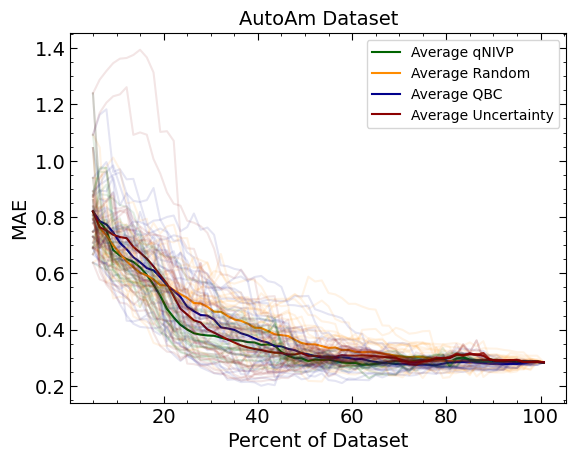

In [ ]:
plt.plot(x_percentages,average_mae_qnipv, color='darkgreen', label='Average qNIVP')
plt.plot(x_percentages,average_mae_rand, color='darkorange', label='Average Random')
plt.plot(x_percentages,average_mae_commit, color='darkblue', label='Average QBC')
plt.plot(x_percentages,average_mae_uncr, color='darkred', label='Average Uncertainty')
# colors = ['crimson','crimson','crimson','crimson','crimson']
# colors = ['crimson']
# Blue, Orange, Green
colors_qnipv = ['purple']
for mae_values in random_runs:
    plt.plot(x_percentages,mae_values, color='darkorange',alpha=0.1)

for mae_values in qnipv_runs[0]:
    plt.plot(x_percentages,mae_values, color='darkgreen',alpha=0.1) 

for mae_values in qbc_runs:
    plt.plot(x_percentages,mae_values, color='darkblue',alpha=0.1)
    
for mae_values in uncertainty_runs:
    plt.plot(x_percentages,mae_values, color='darkred',alpha=0.1)

# for mae_values, seed, color in zip(pred_mae, random_trials, colors_qnipv):
#     plt.plot(mae_values, label=f'qnipv {seed}', color=color, alpha=0.2)


plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.minorticks_on()
plt.title('AutoAm Dataset', size=14)
plt.xlabel('Percent of Dataset', size=14)
plt.ylabel('MAE', size=14)
plt.legend()
plt.show()

### sklearn normalizing function

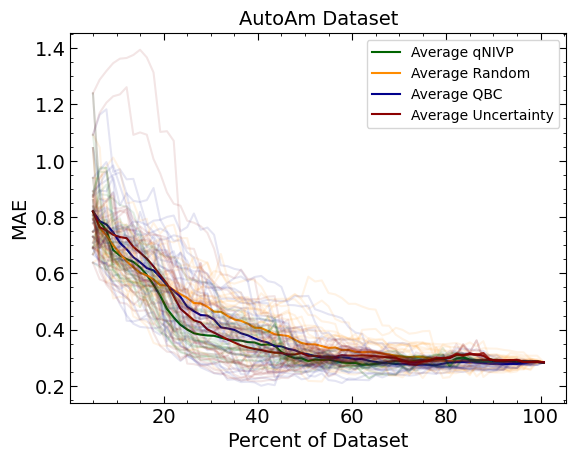

In [179]:
# average_mae_commit = np.mean(qbc_runs, axis=0)
# average_mae_rand = np.mean(random_runs, axis=0)
# average_mae_qnipv = np.mean(qnipv_runs, axis=0)
# average_mae_uncr = np.mean(uncertainty_runs, axis=0)

plt.plot(x_percentages,average_mae_qnipv, color='darkgreen', label='Average qNIVP')
plt.plot(x_percentages,average_mae_rand, color='darkorange', label='Average Random')
plt.plot(x_percentages,average_mae_commit, color='darkblue', label='Average QBC')
plt.plot(x_percentages,average_mae_uncr, color='darkred', label='Average Uncertainty')
# colors = ['crimson','crimson','crimson','crimson','crimson']
# colors = ['crimson']
# Blue, Orange, Green
colors_qnipv = ['purple']
for mae_values in random_runs:
    plt.plot(x_percentages,mae_values, color='darkorange',alpha=0.1)

for mae_values in qnipv_runs[0]:
    plt.plot(x_percentages,mae_values, color='darkgreen',alpha=0.1) 

for mae_values in qbc_runs:
    plt.plot(x_percentages,mae_values, color='darkblue',alpha=0.1)
    
for mae_values in uncertainty_runs:
    plt.plot(x_percentages,mae_values, color='darkred',alpha=0.1)

# for mae_values, seed, color in zip(pred_mae, random_trials, colors_qnipv):
#     plt.plot(mae_values, label=f'qnipv {seed}', color=color, alpha=0.2)


plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.minorticks_on()
plt.title('AutoAm Dataset', size=14)
plt.xlabel('Percent of Dataset', size=14)
plt.ylabel('MAE', size=14)
plt.legend()
plt.show()

### Min-Max for all strategies

In [180]:
lower_qnipv = np.min(qnipv_runs[0], axis=0)
upper_qnipv = np.max(qnipv_runs[0], axis=0)

lower_rand = np.min(random_runs, axis=0)
upper_rand = np.max(random_runs, axis=0)

lower_qbc = np.min(qbc_runs, axis=0)
upper_qbc = np.max(qbc_runs, axis=0)

lower_uncr = np.min(uncertainty_runs, axis=0)
upper_uncr = np.max(uncertainty_runs, axis=0)

### Average runs

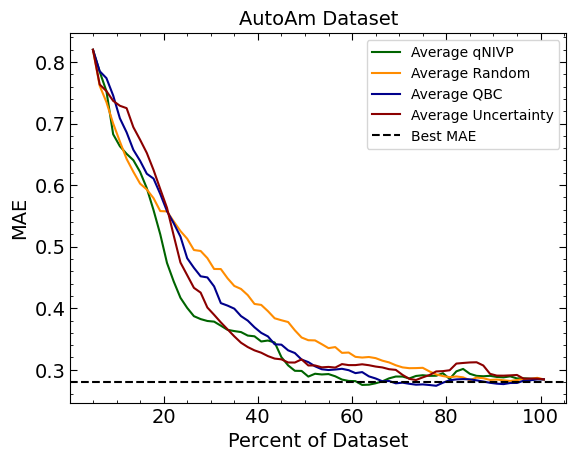

In [182]:
plt.plot(x_percentages,average_mae_qnipv, color='darkgreen', label='Average qNIVP')
plt.plot(x_percentages,average_mae_rand, color='darkorange', label='Average Random')
plt.plot(x_percentages,average_mae_commit, color='darkblue', label='Average QBC')
plt.plot(x_percentages,average_mae_uncr, color='darkred', label='Average Uncertainty')
# plot horizontal line for the best MAE
plt.axhline(y=0.28, color='k', linestyle='--', label='Best MAE')
plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.minorticks_on()
plt.title('AutoAm Dataset', size=14)
plt.xlabel('Percent of Dataset', size=14)
plt.ylabel('MAE', size=14)
plt.legend()
plt.show()

In [ ]:
# import npy files from results folder
qnipv_runs = np.load('AM_qnipv_runs.npy')


In [189]:
qnipv_std = np.std(qnipv_runs[0],axis=0)

random_std = np.std(random_runs, axis=0)

qbc_std = np.std(qbc_runs, axis=0)

uncertainty_std = np.std(uncertainty_runs, axis=0)

In [ ]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('MAE Across Different Sampling Strategies')

# Plot a horizontal line at y=0.28 for all subplots
for ax in axs.flat:
    ax.axhline(y=0.28, color='k', linestyle='--', label='Best MAE')
    
for ax in axs.flat:
    # Highlight initialization region (0-5%)
    ax.axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
    # You can add more regions if needed:
    # ax.axvspan(50, 60, color='yellow', alpha=0.1, label='Region of Interest')
    
    ax.axhline(y=0.28, color='k', linestyle='--', label='Best MAE')
    ax.axvline(x=5, color='r', linestyle='--', label='Initialize w/ 5%')
    ax.set_xlim([0, 100])
    ax.set_ylim([0.1, 1.3])
    ax.set_xticks(np.arange(0, 101, 10))
    ax.axvline(x=5, color='r', linestyle='--', label='Initialize w/ 5%')

#set the xlim and ylim for all subplots
for ax in axs.flat:
    ax.set_xlim([0, 100])
    ax.set_ylim([0.1, 1.3])

#increment the xticks by 10
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 101, 10))

# First subplot: qNIVP
axs[0, 0].fill_between(x_percentages, np.percentile(qnipv_runs[0],15.9,axis=0),np.percentile(qnipv_runs[0],84.1,axis=0) , ec='none',color='darkgreen', alpha=0.5, label='1 Std Dev Range')
axs[0, 0].fill_between(x_percentages,np.percentile(qnipv_runs[0],2.3,axis=0),np.percentile(qnipv_runs[0],97.7,axis=0) , ec='none',color='darkgreen', alpha=0.3, label='2 Std Dev Range')
axs[0, 0].plot(x_percentages, np.mean(qnipv_runs[0],axis=0), color='darkgreen',alpha=0.7, label='Mean')
axs[0, 0].set_title('qNIVP')
axs[0, 0].set_xlabel('Percent of Dataset')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].legend()

# Second subplot: Random
axs[0, 1].fill_between(x_percentages,np.percentile(random_runs,15.9,axis=0),np.percentile(random_runs,84.1,axis=0), ec='none',color='darkorange', alpha=0.5, label='1 Std Dev Range')
axs[0, 1].fill_between(x_percentages, np.percentile(random_runs,2.3,axis=0),np.percentile(random_runs,97.7,axis=0), ec='none',color='darkorange', alpha=0.3, label='2 Std Dev Range')
axs[0,1].plot(x_percentages, np.mean(random_runs,axis=0), color='darkorange',alpha=0.7, label='Mean')
axs[0, 1].set_title('Random')
axs[0, 1].set_xlabel('Percent of Dataset')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].legend()



axs[1, 0].fill_between(x_percentages, np.percentile(qbc_runs, 15.9,axis=0), np.percentile(qbc_runs, 84.1,axis=0), color='darkblue', alpha=0.5, label='1 Std Dev Range',ec = 'none')
axs[1, 0].fill_between(x_percentages, np.percentile(qbc_runs, 2.3, axis=0),np.percentile(qbc_runs,97.7,axis =0),ec = 'none', color='darkblue', alpha=0.3, label='2 Std Dev Range')
axs[1,0].plot(x_percentages, np.mean(qbc_runs,axis=0),color='darkblue',alpha=0.7, label='Mean')
axs[1, 0].set_title('QBC')
axs[1, 0].set_xlabel('Percent of Dataset')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].legend()



# Fourth subplot: Uncertainty
axs[1, 1].fill_between(x_percentages, np.percentile(uncertainty_runs,15.9,axis=0), np.percentile(uncertainty_runs,84.1,axis=0), ec='none',color='darkred', alpha=0.5, label='1 Std Dev Range')
axs[1, 1].fill_between(x_percentages,np.percentile(uncertainty_runs,2.3,axis=0), np.percentile(uncertainty_runs,97.7,axis=0), ec='none',color='darkred', alpha=0.3, label='2 Std Dev Range')
axs[1, 1].plot(x_percentages, np.mean(uncertainty_runs,axis=0), color='darkred',alpha=0.7, label='Mean')
axs[1, 1].set_title('Uncertainty')
axs[1, 1].set_xlabel('Percent of Dataset')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend()

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust to make room for the main title
plt.show()

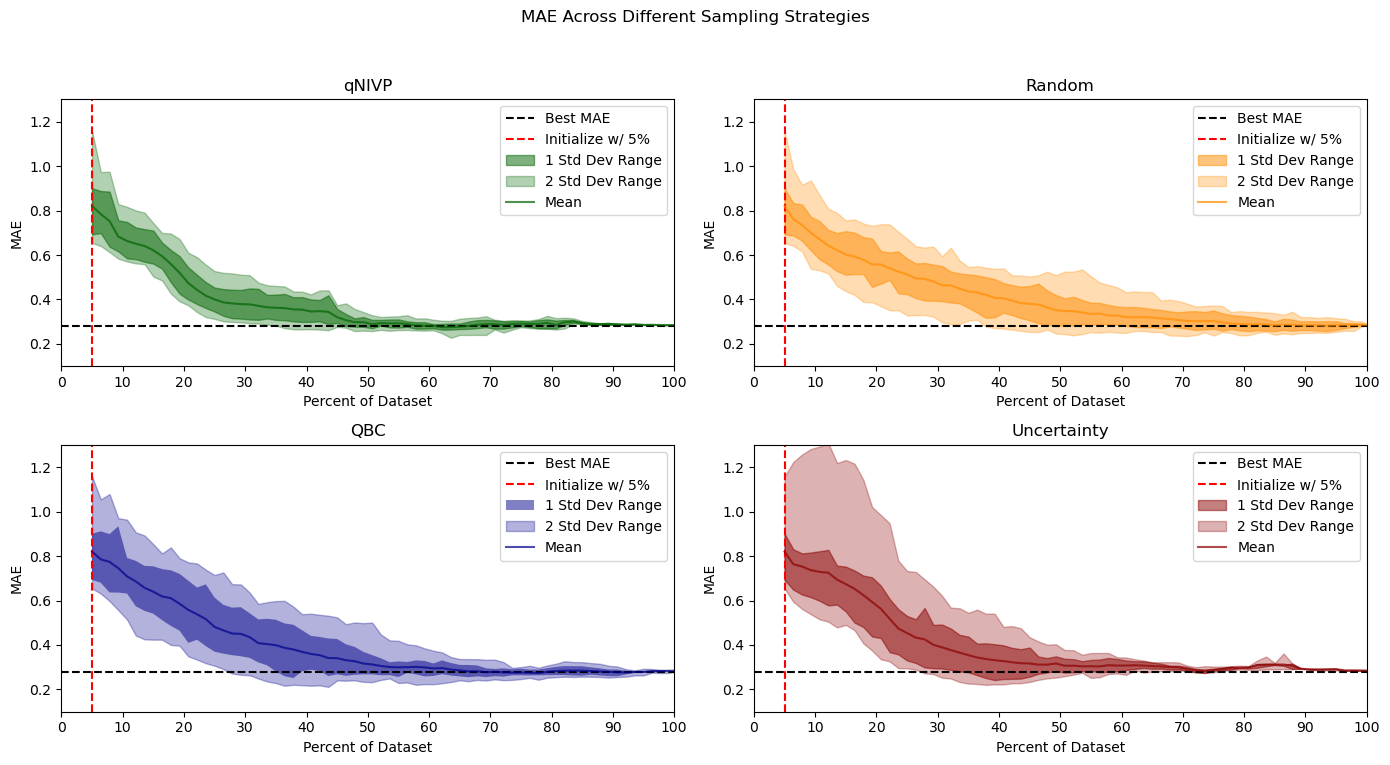

In [ ]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('MAE Across Different Sampling Strategies')

# Plot a horizontal line at y=0.28 for all subplots
for ax in axs.flat:
    ax.axhline(y=0.28, color='k', linestyle='--', label='Best MAE')
    
for ax in axs.flat:
    # Highlight initialization region (0-5%)
    ax.axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
    # You can add more regions if needed:
    # ax.axvspan(50, 60, color='yellow', alpha=0.1, label='Region of Interest')
    
    ax.axhline(y=0.28, color='k', linestyle='--', label='Best MAE')
    ax.axvline(x=5, color='r', linestyle='--', label='Initialize w/ 5%')
    ax.set_xlim([0, 100])
    ax.set_ylim([0.1, 1.3])
    ax.set_xticks(np.arange(0, 101, 10))
    ax.axvline(x=5, color='r', linestyle='--', label='Initialize w/ 5%')

#set the xlim and ylim for all subplots
for ax in axs.flat:
    ax.set_xlim([0, 100])
    ax.set_ylim([0.1, 1.3])

#increment the xticks by 10
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 101, 10))

# First subplot: qNIVP
axs[0, 0].fill_between(x_percentages, np.percentile(qnipv_runs[0],15.9,axis=0),np.percentile(qnipv_runs[0],84.1,axis=0) , ec='none',color='darkgreen', alpha=0.5, label='1 Std Dev Range')
axs[0, 0].fill_between(x_percentages,np.percentile(qnipv_runs[0],2.3,axis=0),np.percentile(qnipv_runs[0],97.7,axis=0) , ec='none',color='darkgreen', alpha=0.3, label='2 Std Dev Range')
axs[0, 0].plot(x_percentages, np.mean(qnipv_runs[0],axis=0), color='darkgreen',alpha=0.7, label='Mean')
axs[0, 0].set_title('qNIVP')
axs[0, 0].set_xlabel('Percent of Dataset')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].legend()

# Second subplot: Random
axs[0, 1].fill_between(x_percentages,np.percentile(random_runs,15.9,axis=0),np.percentile(random_runs,84.1,axis=0), ec='none',color='darkorange', alpha=0.5, label='1 Std Dev Range')
axs[0, 1].fill_between(x_percentages, np.percentile(random_runs,2.3,axis=0),np.percentile(random_runs,97.7,axis=0), ec='none',color='darkorange', alpha=0.3, label='2 Std Dev Range')
axs[0,1].plot(x_percentages, np.mean(random_runs,axis=0), color='darkorange',alpha=0.7, label='Mean')
axs[0, 1].set_title('Random')
axs[0, 1].set_xlabel('Percent of Dataset')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].legend()



axs[1, 0].fill_between(x_percentages, np.percentile(qbc_runs, 15.9,axis=0), np.percentile(qbc_runs, 84.1,axis=0), color='darkblue', alpha=0.5, label='1 Std Dev Range',ec = 'none')
axs[1, 0].fill_between(x_percentages, np.percentile(qbc_runs, 2.3, axis=0),np.percentile(qbc_runs,97.7,axis =0),ec = 'none', color='darkblue', alpha=0.3, label='2 Std Dev Range')
axs[1,0].plot(x_percentages, np.mean(qbc_runs,axis=0),color='darkblue',alpha=0.7, label='Mean')
axs[1, 0].set_title('QBC')
axs[1, 0].set_xlabel('Percent of Dataset')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].legend()



# Fourth subplot: Uncertainty
axs[1, 1].fill_between(x_percentages, np.percentile(uncertainty_runs,15.9,axis=0), np.percentile(uncertainty_runs,84.1,axis=0), ec='none',color='darkred', alpha=0.5, label='1 Std Dev Range')
axs[1, 1].fill_between(x_percentages,np.percentile(uncertainty_runs,2.3,axis=0), np.percentile(uncertainty_runs,97.7,axis=0), ec='none',color='darkred', alpha=0.3, label='2 Std Dev Range')
axs[1, 1].plot(x_percentages, np.mean(uncertainty_runs,axis=0), color='darkred',alpha=0.7, label='Mean')
axs[1, 1].set_title('Uncertainty')
axs[1, 1].set_xlabel('Percent of Dataset')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend()

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust to make room for the main title
plt.show()


### parity plots

In [301]:
ytest_parity = ytest.squeeze().numpy()
ytest_parity.shape

(30,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


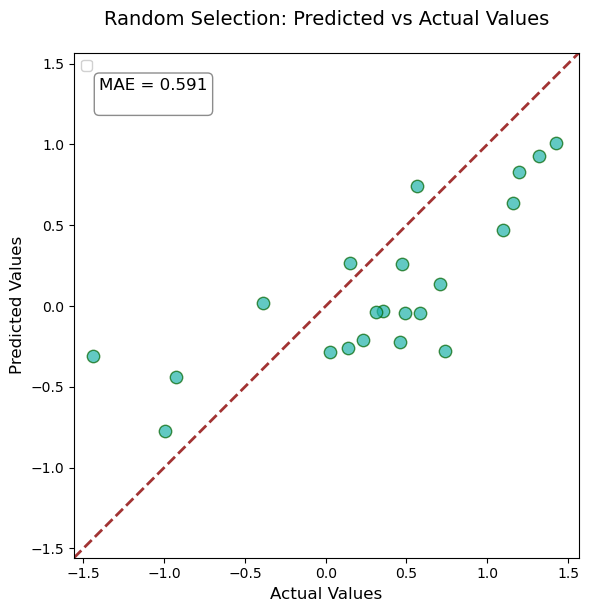

In [69]:
def create_detailed_parity_plot(y_test, y_pred, 
                              title="Prediction vs Actual",
                              xlabel="Actual Values", 
                              ylabel="Predicted Values",
                              point_color='cornflowerblue',
                              edge_color='navy',
                              line_color='red',
                              fontsize=12,
                              alpha=0.6,
                              point_size=100,
                              add_statistics=True,
                              grid_style='--',
                              grid_alpha=0.3):
    """
    Creates a detailed parity plot with customizable features.
    """
    
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # Calculate range
    min_val = min(min(y_test), min(y_pred)) * 0.9
    max_val = max(max(y_test), max(y_pred)) * 1.1
    range_val = [min_val, max_val]
    
    # Plot parity line
    ax.plot(range_val, range_val, '--', color=line_color, alpha=0.8, linewidth=2, zorder=1)
    
    # Create scatter plot
    scatter = ax.scatter(y_test, y_pred, 
                        alpha=alpha,
                        c=point_color,
                        edgecolors=edge_color,
                        s=point_size,
                        zorder=2)
    
    if add_statistics:
        # Calculate statistics
        # r2 = np.corrcoef(y_test, y_pred)[0,1]**2
        mae = np.mean(np.abs(y_test - y_pred))
        # rmse = np.sqrt(np.mean((y_test - y_pred)**2))
        
        # Add statistics text
        # f'R² = {r2:.3f}\n'
        # f'RMSE = {rmse:.3f}'
        stats_text = (
                     f'MAE = {mae:.3f}\n'
                     )
        
        plt.text(0.05, 0.95, stats_text,
                transform=ax.transAxes,
                fontsize=fontsize,
                verticalalignment='top',
                bbox=dict(boxstyle='round',
                         facecolor='white',
                         alpha=0.9,
                         edgecolor='gray'))
    
    # Customize the plot
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize+2, pad=20)
    
    # Make axes equal
    ax.set_aspect('equal')
    
    # Add grid
    # ax.grid(True, linestyle=grid_style, alpha=grid_alpha)
    
    # Set limits
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
    
    # Add legend
    ax.legend(fontsize=fontsize-2, framealpha=0.9)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

# ytest, rand_ypred_mean
# Example usage with custom settings:
fig, ax = create_detailed_parity_plot(
    ytest_parity, 
    rand_ypred_mean,
    title="Random Selection: Predicted vs Actual Values",
    point_color='lightseagreen',
    edge_color='darkgreen',
    line_color='darkred',
    alpha=0.7,
    point_size=80,
    grid_alpha=0.2
)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


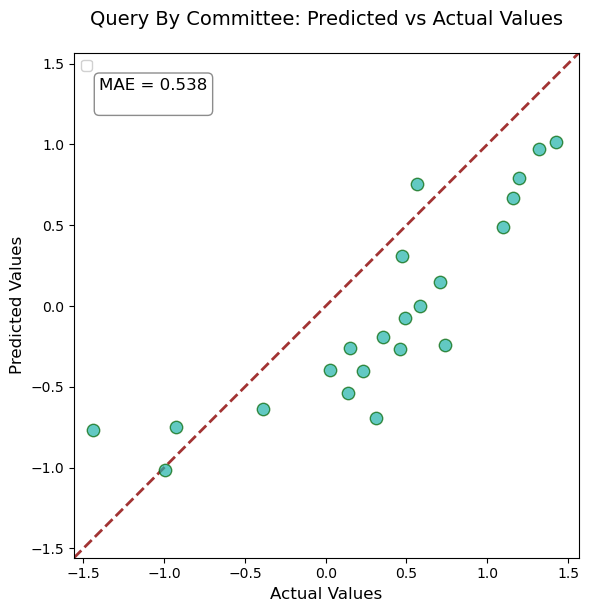

In [70]:
fig, ax = create_detailed_parity_plot(
    ytest_parity, 
    ypred,
    title="Query By Committee: Predicted vs Actual Values",
    point_color='lightseagreen',
    edge_color='darkgreen',
    line_color='darkred',
    alpha=0.7,
    point_size=80,
    grid_alpha=0.2
)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


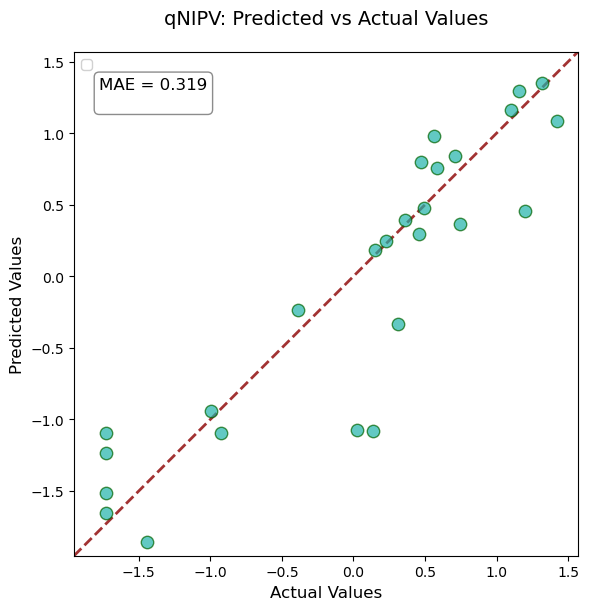

In [71]:
fig, ax = create_detailed_parity_plot(
    ytest_parity, 
    ypred_mean,
    title="qNIPV: Predicted vs Actual Values",
    point_color='lightseagreen',
    edge_color='darkgreen',
    line_color='darkred',
    alpha=0.7,
    point_size=80,
    grid_alpha=0.2
)
plt.show()